In [1]:
import rioxarray as xr
import os
import glob
import pandas as pd
import xarray

In [2]:
# round the coordinates to the nearest 10
def round_coord(x):
    return (x/10).round()*10

In [3]:
# filter land use ids
def cultivable_areas_only(data):
    cultivable_ids = [11, 12, 13, 14, 15, 16]
    return data.loc[data.band.isin(cultivable_ids)]

In [4]:
def tifToDataframe(tifPath):
    
    xarray = xr.open_rasterio(tifPath)
    xarray = xarray.assign_coords(x = round_coord(xarray.x), y = round_coord(xarray.y)).drop_vars(["spatial_ref"])
    # 'band' : name of the data variable (!to dataset inverts x and y order)
    dataframe = xarray.to_dataset('band').to_dataframe()
    
    return dataframe

## One week cultivable areas filtering for each region

In [5]:
raster_folder_cultregions = "./rasters/cult_regions/"
rasters_cultregions = glob.glob(raster_folder_cultregions+'*.tif')
rasters_cultregions.sort()
rasters_cultregions

['./rasters/cult_regions/Adda.tif',
 './rasters/cult_regions/Dora.tif',
 './rasters/cult_regions/Emiliani1.tif',
 './rasters/cult_regions/Emiliani2.tif',
 './rasters/cult_regions/GardaMincio.tif',
 './rasters/cult_regions/Lambro_Olona.tif',
 './rasters/cult_regions/OglioIseo.tif',
 './rasters/cult_regions/Piemonte_Nord.tif',
 './rasters/cult_regions/Piemonte_Sud.tif',
 './rasters/cult_regions/Ticino.tif']

In [6]:
raster_folder_vhiregions = "./rasters/vhi_regions/"
rasters_vhiregions = glob.glob(raster_folder_vhiregions+'*.tif')
rasters_vhiregions.sort()
rasters_vhiregions

['./rasters/vhi_regions/Adda_vhi.tif',
 './rasters/vhi_regions/Dora_vhi.tif',
 './rasters/vhi_regions/Emiliani1_vhi.tif',
 './rasters/vhi_regions/Emiliani2_vhi.tif',
 './rasters/vhi_regions/GardaMincio_vhi.tif',
 './rasters/vhi_regions/Lambro_Olona_vhi.tif',
 './rasters/vhi_regions/OglioIseo_vhi.tif',
 './rasters/vhi_regions/Piemonte_Nord_vhi.tif',
 './rasters/vhi_regions/Piemonte_Sud_vhi.tif',
 './rasters/vhi_regions/Ticino_vhi.tif']

In [ ]:
joins = [[] for i in range(len(rasters_cultregions))]

for i in range(len(rasters_cultregions)):
    
    cult_df = tifToDataframe(rasters_cultregions[i])
    print("Dataframe ", i, " generated")
    
    # Remove rows related to no-data band
    cult_df = cult_df[cult_df.band != 255]
    print("Removed no-data band")
    
    cult_df = cultivable_areas_only(cult_df)
    print("Non cultivable areas removed")
    
    vhi_df = tifToDataframe(rasters_vhiregions[i])
    print("Dataframe ", i, " of vhi generated")
    
    # Remove rows related to no-data band
    vhi_df = vhi_df.loc[vhi_df.band > 0.0]
    print("Removed no-data band")
    
    joins[i] = vhi_df.join(cult_df, how = 'inner', lsuffix = '_vhi', rsuffix = '_id')
    print("Join ", i, " completed")

In [ ]:
filtered_vhi_rasters = [[] for i in range(len(joins))]

for i in range(len(joins)):
    xarray = joins[i].to_xarray()
    xarray = xarray.rio.set_crs('epsg:3035')
    filtered_vhi_rasters[i] = rasters_vhiregions[i].replace("vhi_regions", "filtered_vhi") # paths
    xarray.rio.to_raster(filtered_vhi_rasters[i])

## Emiliani2 cultivable areas filtering for all years and weeks

In [75]:
origin_dir = os.getcwd()
os.chdir(origin_dir + '/rasters/vhi_regions')

In [76]:
# here are the dates of start and end of each division of the range
dates = [['2001-01-05', '2009-12-29'], ['2010-01-06', '2019-12-25'], ['2020-01-02', '2022-08-19']]

In [77]:
regions = [r for r in os.listdir() if not r.startswith('.')]
regions

['Adda',
 'Dora',
 'Emiliani1',
 'Piemonte_Sud',
 'Piemonte_Nord',
 'Oglio_Iseo',
 'Ticino',
 'Garda_Mincio',
 'Lambro_Olona',
 'Emiliani2']

In [79]:
regions_dir = origin_dir + '/rasters/vhi_regions'
# 10x3 structure to save statistics for each region and range
stat_per_range = [[] for i in range(len(rasters))]
stat_per_region = [list(stat_per_range) for i in range(len(regions))]   

for i in range(len(regions)):
    region_dir = regions_dir + '/' + regions[i]
    os.chdir(region_dir)
    rasters = [r for r in os.listdir() if (r.endswith('.tif') and not r.startswith('.'))]
    rasters.sort()
    
    cult_df = tifToDataframe(region_dir.replace("vhi_regions", "cult_regions") + '.tif')
    cult_df = cult_df.rename(columns={1:'band'})
    # Remove rows related to no-data band
    cult_df = cult_df[cult_df.band != 255]
    cult_df = cultivable_areas_only(cult_df)
    print("Cultivable points for", regions[i], "extracted")
    
    for j in range(len(rasters)):

        vhi_df = tifToDataframe(region_dir + '/' + rasters[j])
        # rename columns with related dates
        cols = pd.date_range(start=dates[j][0], end=dates[j][1], freq = '8D')
        vhi_df.columns = cols.strftime('%Y-%m-%d')
        print("Dataframe ", j, " of region ", regions[i], " generated")
        
        join = vhi_df.join(cult_df, how = 'inner', lsuffix = '_vhi', rsuffix = '_id')
        print("Removed non cultivable areas from vhi dataframe ", j)
        
        df = join
        df = df.iloc[: , :-1] # remove the last column related to the band of land use
        df_dates = df.columns # save columns (dates)
        # store means and medians in two vectors
        means = [[] for m in range(len(df.columns))]
        medians = [[] for n in range(len(df.columns))]

        z = 0
        for column in df:
            means[z] = df[column].median()
            medians[z] = df[column].mean()
            z = z + 1
        
        stat_per_region[i][j] = pd.DataFrame({'mean': means, 'median': medians},    # values
                      index=df_dates)
        
        # concatenate the stat of the 3 intervals of years
        stat_per_region_final = [[] for i in range(len(regions))]

        for i in range(len(regions)):
            stat_per_region_final[i] = stat_per_region[i][0]
            for j in range(len(rasters) - 1):
                stat_per_region_final[i] = pd.concat([stat_per_region_final[i], stat_per_region[i][j+1]])
        
        xarray = join.to_xarray()
        xarray = xarray.rio.set_crs('epsg:3035')

        filtered_vhi_rasters = region_dir.replace("vhi_regions", "filtered_vhi") + '/' + rasters[j] # destination paths
        xarray.rio.to_raster(filtered_vhi_rasters)
        print("Raster ", j, "generated")

Cultivable points for Adda extracted
Dataframe  0  of region  Adda  generated
Removed non cultivable areas from vhi dataframe  0
Dataframe  1  of region  Adda  generated
Removed non cultivable areas from vhi dataframe  1
Dataframe  2  of region  Adda  generated
Removed non cultivable areas from vhi dataframe  2
Cultivable points for Dora extracted
Dataframe  0  of region  Dora  generated
Removed non cultivable areas from vhi dataframe  0
Dataframe  1  of region  Dora  generated
Removed non cultivable areas from vhi dataframe  1
Dataframe  2  of region  Dora  generated
Removed non cultivable areas from vhi dataframe  2
Cultivable points for Emiliani1 extracted
Dataframe  0  of region  Emiliani1  generated
Removed non cultivable areas from vhi dataframe  0
Dataframe  1  of region  Emiliani1  generated
Removed non cultivable areas from vhi dataframe  1
Dataframe  2  of region  Emiliani1  generated
Removed non cultivable areas from vhi dataframe  2
Cultivable points for Piemonte_Sud extrac

/Users/veronica/anaconda3/envs/openeo/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


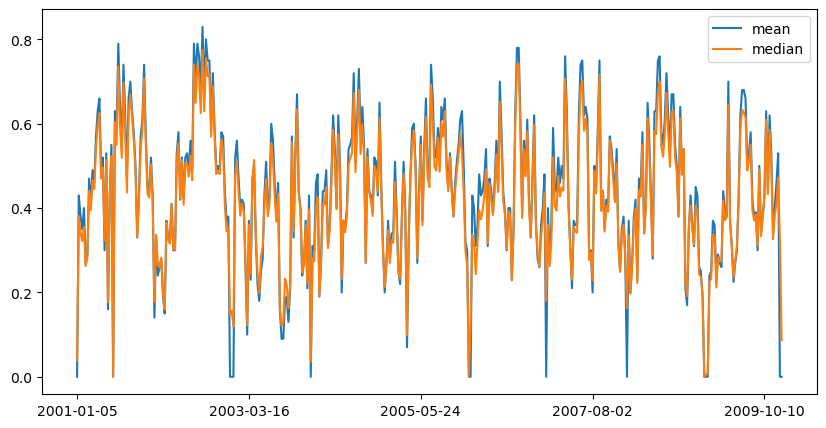

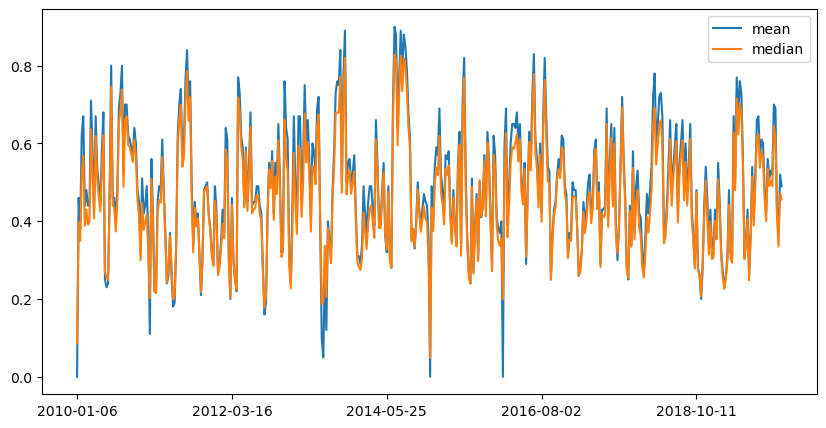

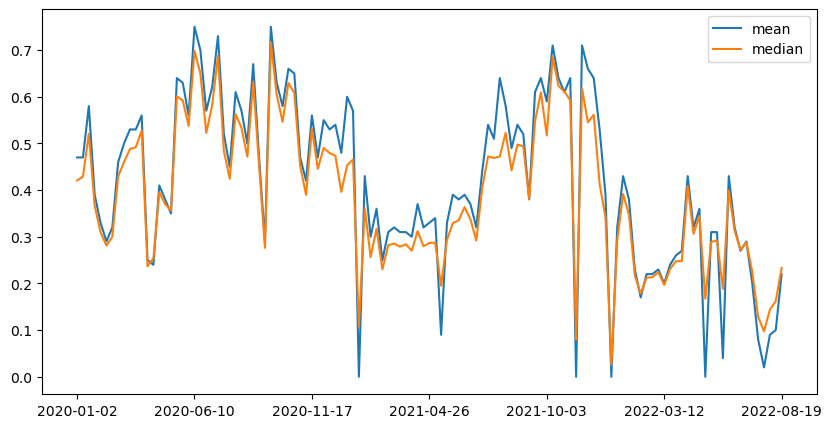

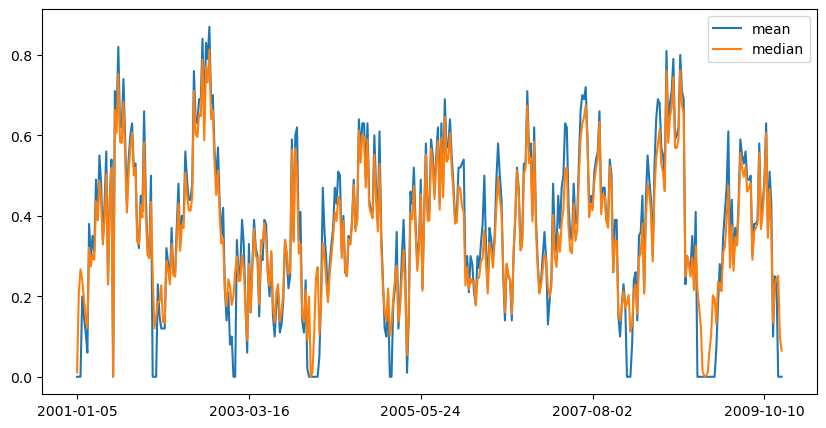

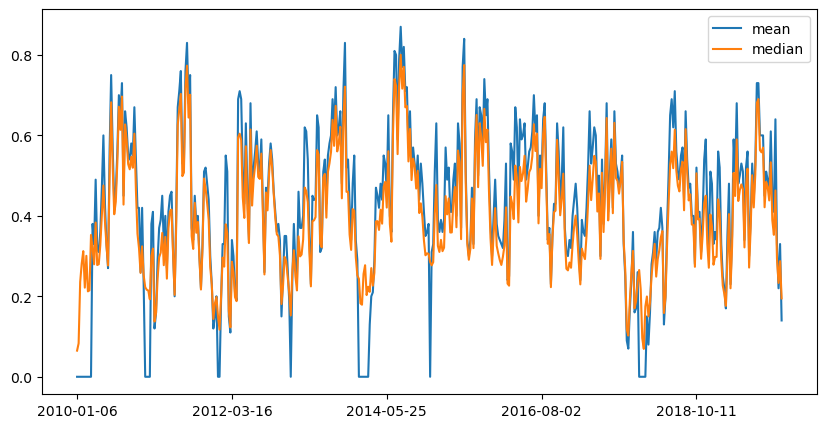

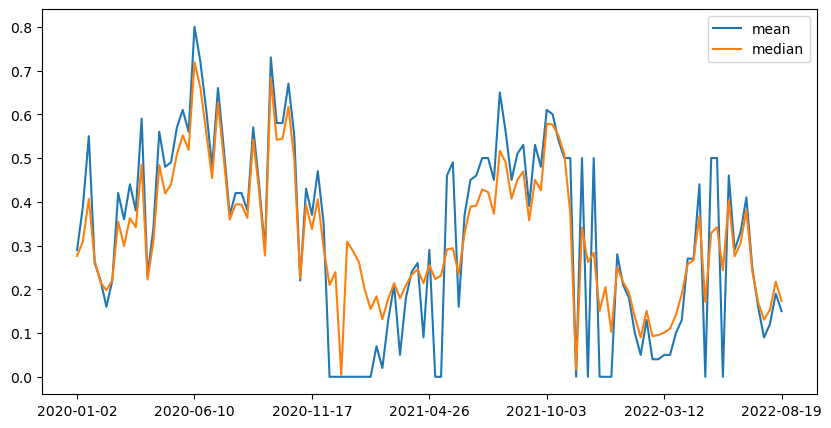

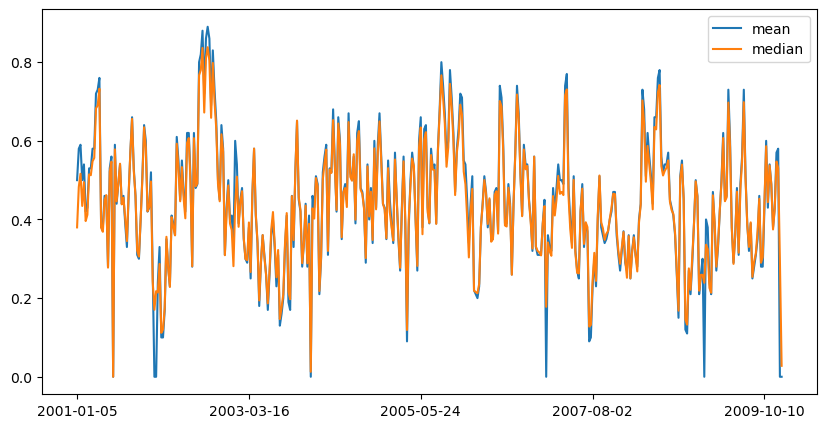

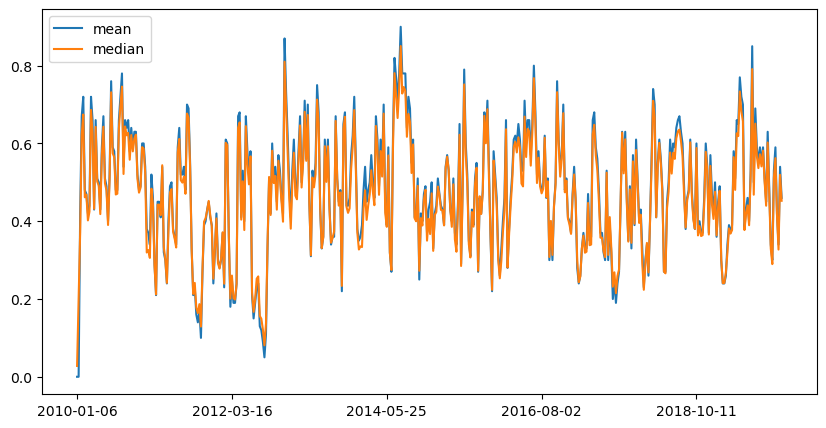

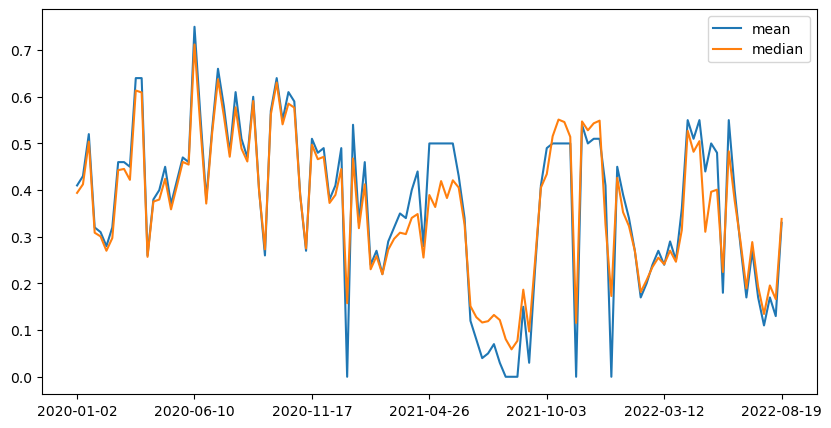

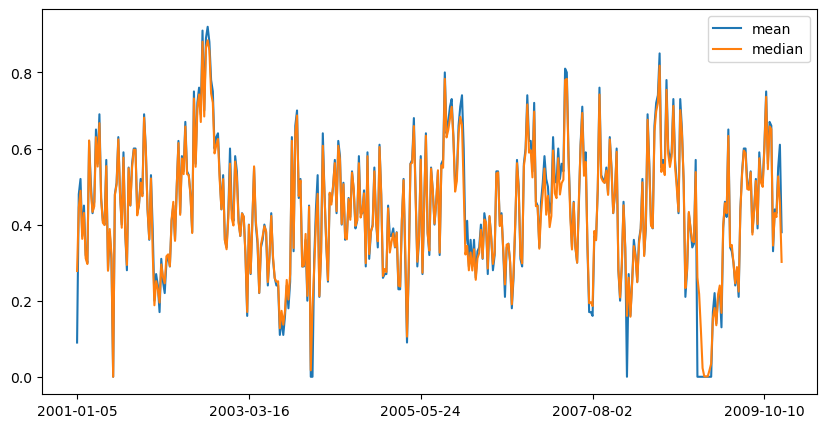

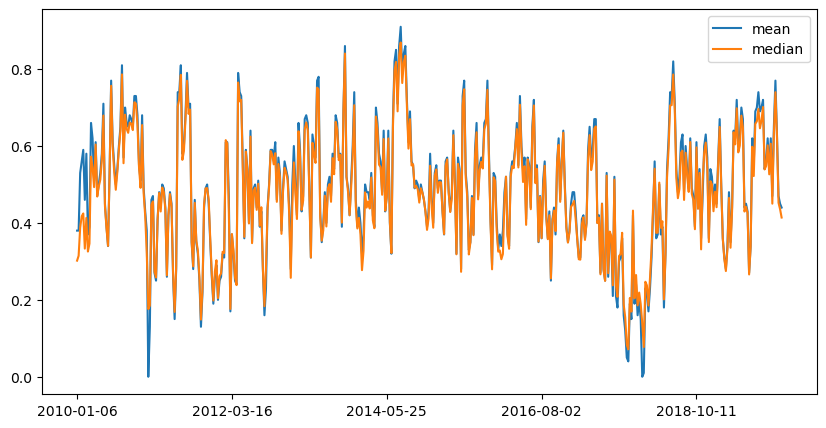

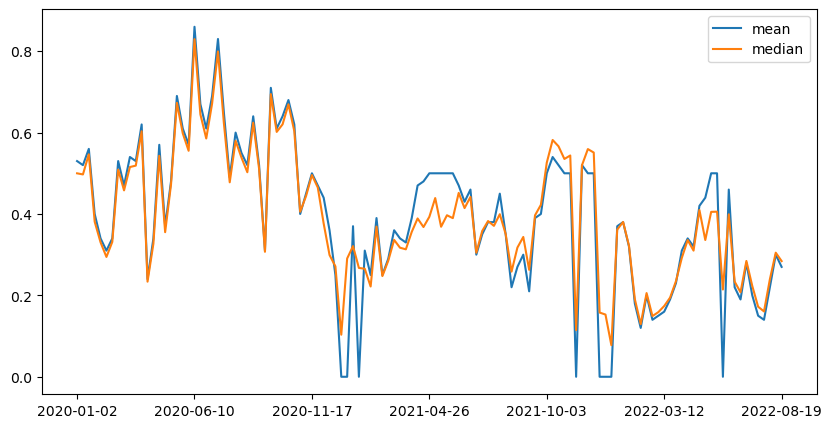

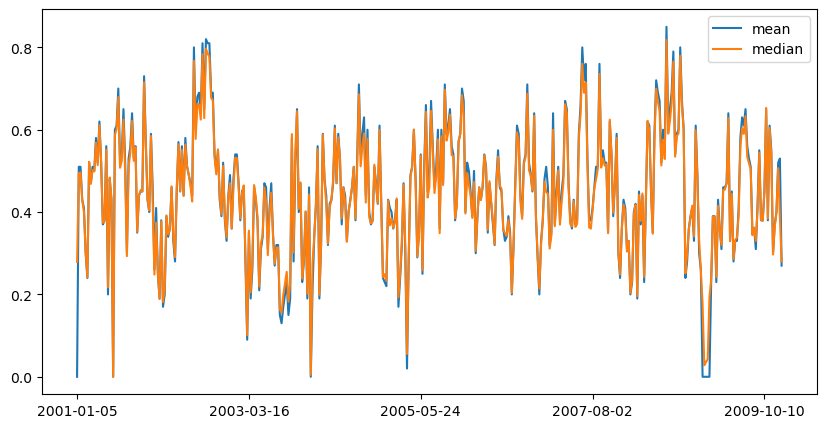

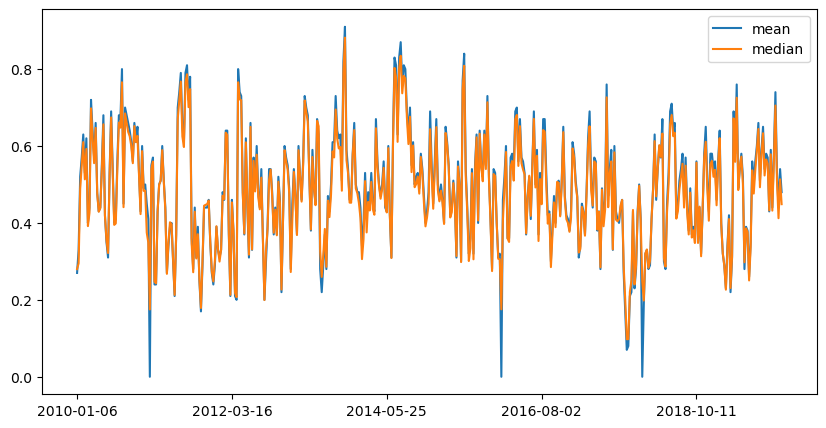

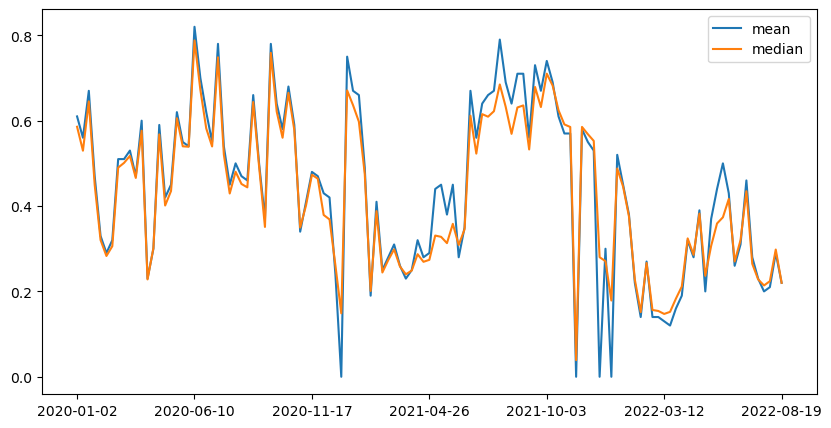

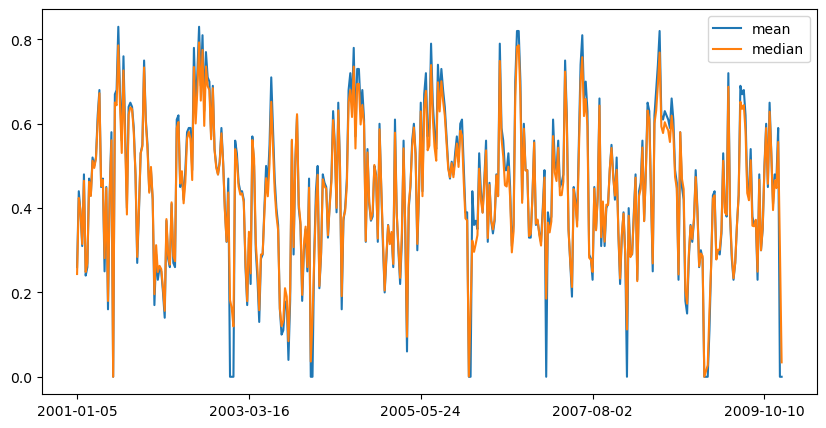

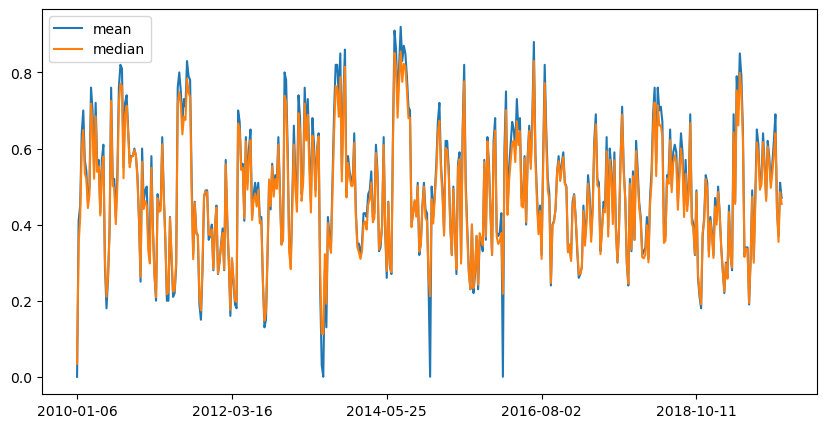

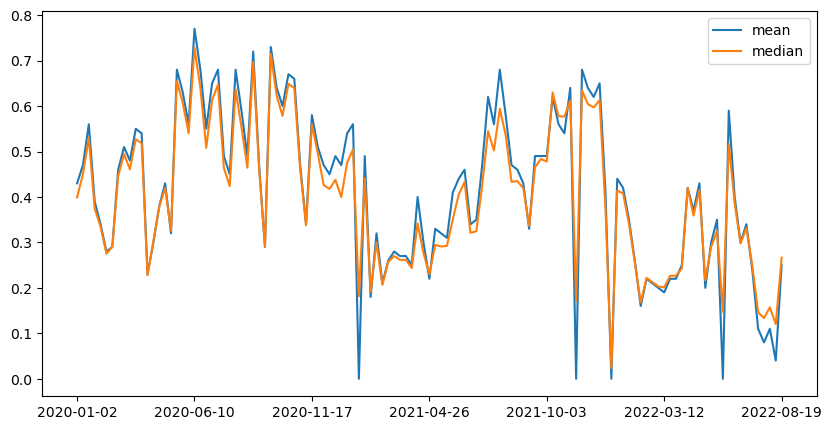

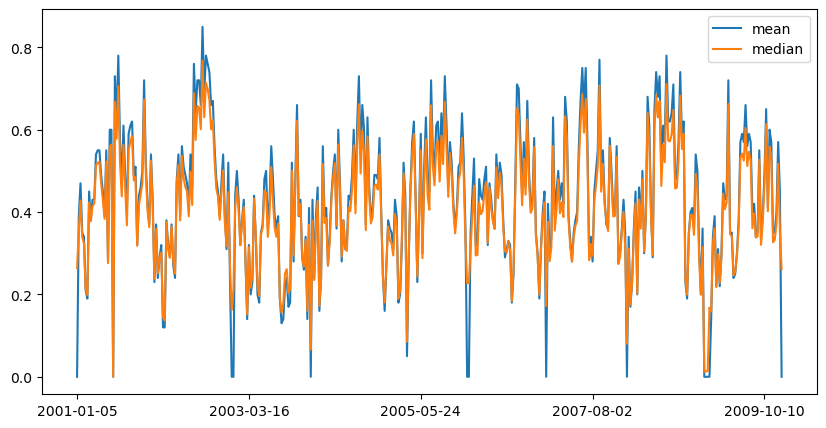

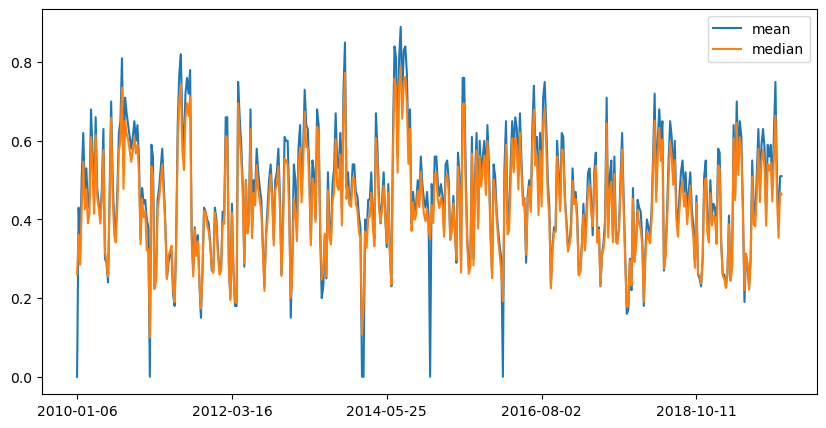

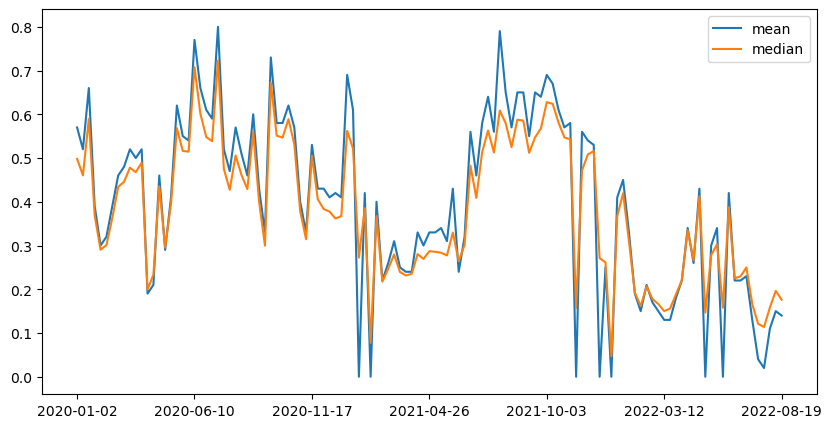

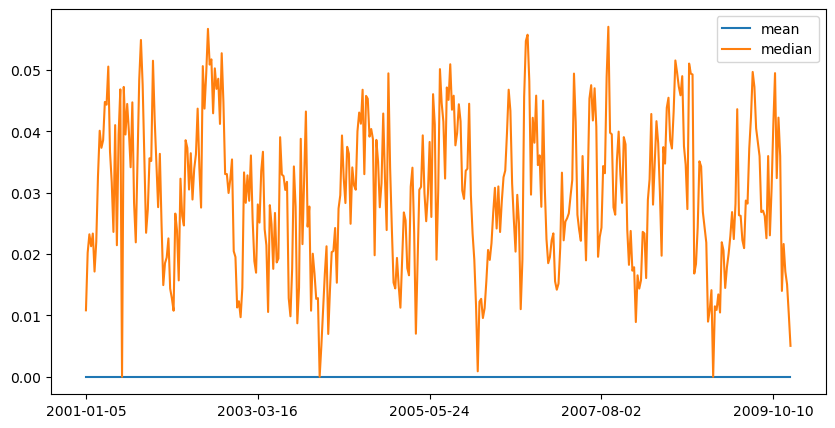

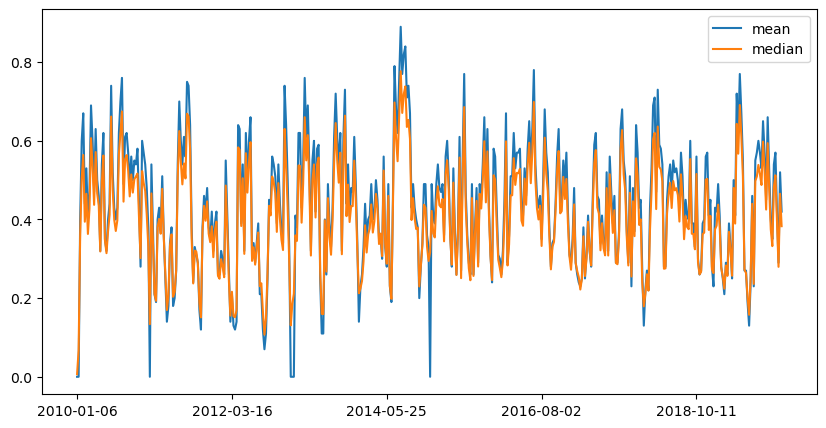

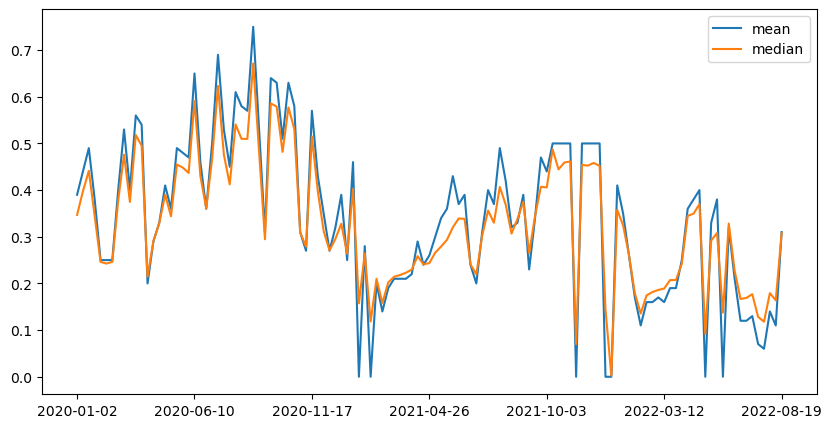

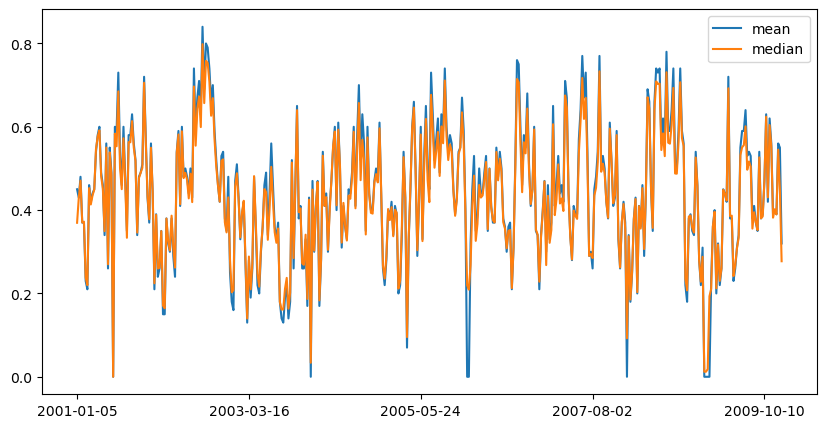

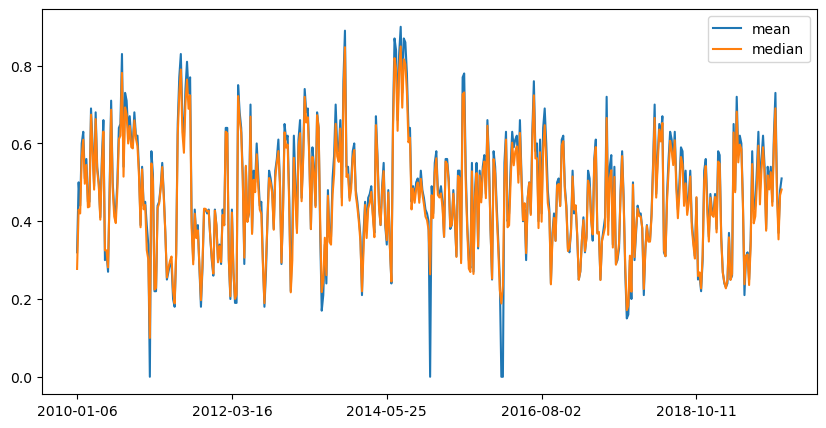

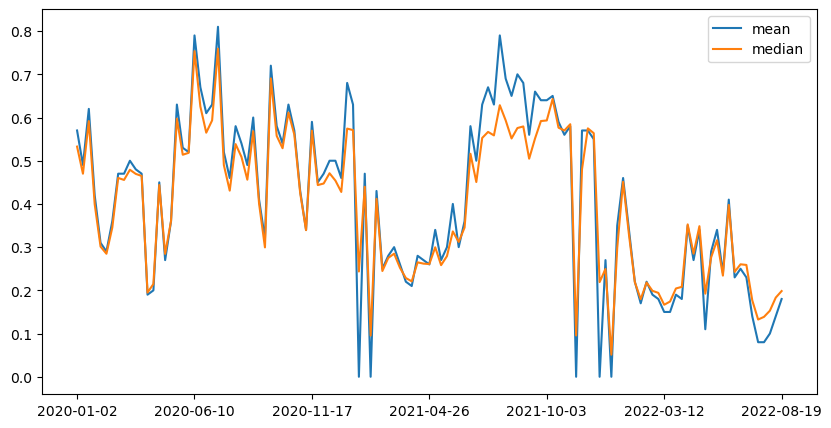

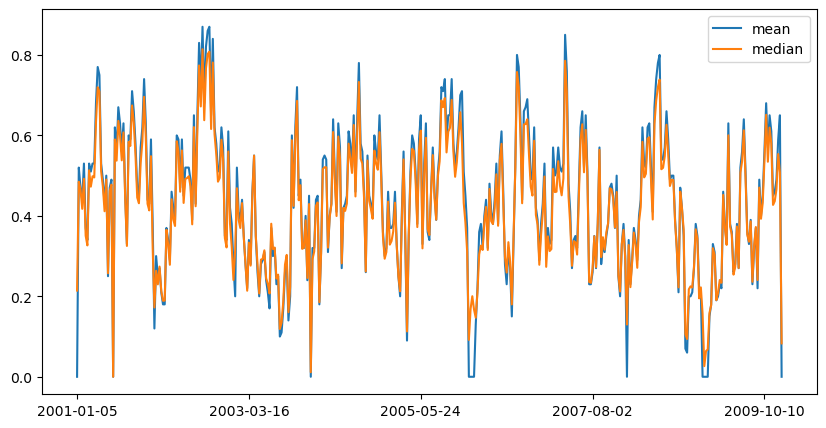

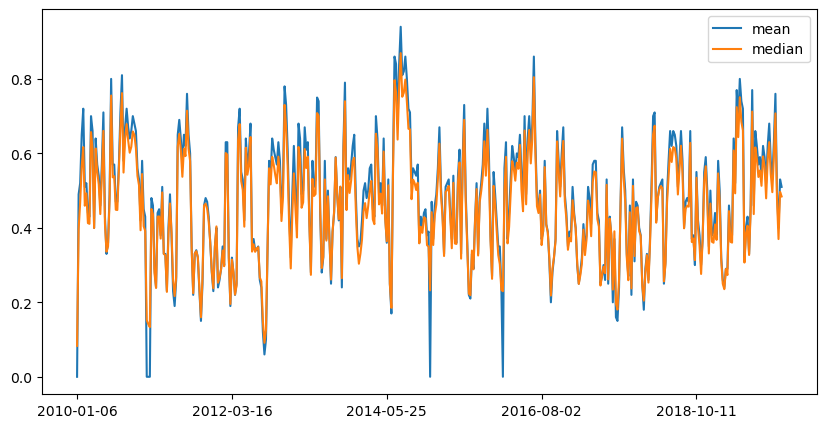

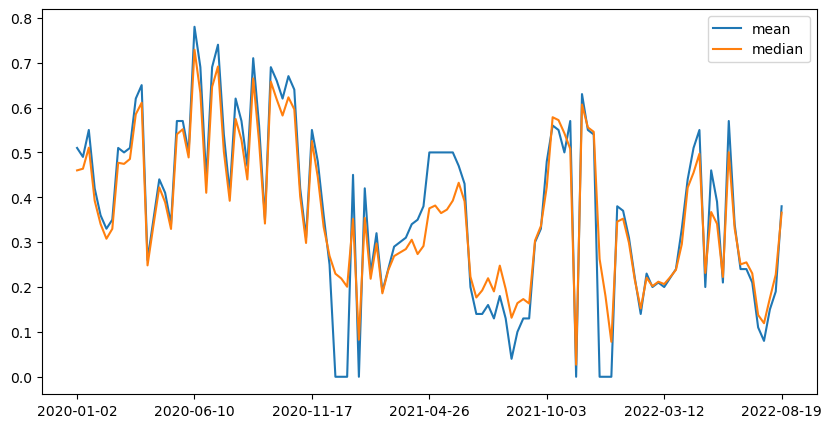

In [82]:
for i in range(len(regions)):
    for j in range(len(rasters)):
        stat_per_region[i][j].plot(figsize=(10,5))

In [125]:
stat_per_region_final[0]

,mean,median
2001-01-05,0.00,0.214281
2001-01-13,0.52,0.484737
2001-01-21,0.47,0.466071
2001-01-29,0.44,0.417470
2001-02-06,0.53,0.492202
...,...,...
2022-07-18,0.08,0.128432
2022-07-26,0.02,0.097476
2022-08-03,0.09,0.143911
2022-08-11,0.10,0.162068


In [144]:
from datetime import datetime

num_data = len(stat_per_region_final[0].index.values)

years = [[] for i in range(num_data)]
weeks = [[] for i in range(num_data)]
                           
for i in range(num_data):
    years[i] = datetime.strptime(stat_per_region_final[0].index.values[i], '%Y-%m-%d').year
    weeks[i] = datetime.strptime(stat_per_region_final[0].index.values[i], '%Y-%m-%d').isocalendar().week

for i in range(len(regions)):
    stat_per_region_final[i]['Year'] = years
    stat_per_region_final[i]['Week'] = weeks

In [145]:
for i in range(len(regions)):
    stat_per_region_final[i].to_csv(regions[i] + ".csv", index=False)

[            mean    median  Year  Week
 2001-01-05  0.00  0.214281  2001     1
 2001-01-13  0.52  0.484737  2001     2
 2001-01-21  0.47  0.466071  2001     3
 2001-01-29  0.44  0.417470  2001     5
 2001-02-06  0.53  0.492202  2001     6
 ...          ...       ...   ...   ...
 2022-07-18  0.08  0.128432  2022    29
 2022-07-26  0.02  0.097476  2022    30
 2022-08-03  0.09  0.143911  2022    31
 2022-08-11  0.10  0.162068  2022    32
 2022-08-19  0.22  0.233251  2022    33
 
 [988 rows x 4 columns],
             mean    median  Year  Week
 2001-01-05  0.00  0.010645  2001     1
 2001-01-13  0.00  0.206769  2001     2
 2001-01-21  0.00  0.267313  2001     3
 2001-01-29  0.20  0.240836  2001     5
 2001-02-06  0.15  0.193417  2001     6
 ...          ...       ...   ...   ...
 2022-07-18  0.16  0.170667  2022    29
 2022-07-26  0.09  0.130687  2022    30
 2022-08-03  0.12  0.152509  2022    31
 2022-08-11  0.19  0.217110  2022    32
 2022-08-19  0.15  0.173345  2022    33
 
 [988 rows 